In [238]:
# import libraries
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPolygon
import shapely.wkt
from path import Path
import os
import sys
import re
from functools import reduce

In [240]:
from shapely import wkt

In [242]:
# path configuration
working_directory = Path.getcwd()
inputs_path = working_directory / 'inputs'
outputs_path = working_directory / 'outputs'

In [244]:
infile = inputs_path/ 'Use_Buffer_Exp_FeaturesToJSO.geojson'

<H1> Important Functions </H1>

In [360]:
# export function
def to_file(callback, desired_name, extension='csv'):
    current_files = sorted(outputs_path.files(desired_name + '*.' + extension))
    if current_files:
        last_file = current_files[-1]
        os.remove(last_file)
    final_name = '{}.{}'.format(desired_name, extension)
    callback(outputs_path / final_name)
    
#merge to geo
#this isn't used in this particular script, but once you have your geojsons, you can avoid having to swap
#back to QGIS by using this function in your data cleaning scripts to join dataframes to a geodataframe
def _geo_merge(frame,geo_frames_dictionary,geo):
    if isinstance(frame.columns, pandas.core.index.MultiIndex):
        frame.columns = [
            '-'.join(x)
            for x in frame.columns.values
        ]
    current_geo = geo_frames_dictionary[geo]
    with_geo = current_geo.merge(frame, left_index=True,right_index=True).drop('',errors='ignore')
    return with_geo

# Import geos
def import_geos(path,index_name):
    shapes = geopandas.read_file(path)
    shapes.plot()
    output_frame = shapes[['name','geometry']]
    return output_frame

In [362]:
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

lat_point_list = list(gdf.Latitude.unique())
lon_point_list = list(gdf.Longitude.unique())

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
multipolygon_geom = MultiPolygon([polygon_geom])

In [364]:
gdf = geopandas.read_file(infile)

In [366]:
# function to serialize geometry to text string
def to_wkt(x):
    try:
        return shapely.wkt.loads(x)
    except:
        return None

In [368]:
# simplify geometries to avoid a query with 1M+ characters
gdf['geometry'] = gdf['geometry'].simplify(0.05).buffer(0.)

In [370]:
# convert geometry to shapely object
gdf['geometry'] = gdf['geometry'].apply(lambda x: MultiPolygon([x]))

In [372]:
to_drop = ['BUFF_DIST','ORIG_FID']
gdf = gdf.drop(to_drop,axis=1)
gdf.rename(columns={'OBJECTIT':'id'},inplace=True)

In [388]:
# export
with open('MoDotMNA.geojson' , 'w') as file:
    file.write(gdf.to_json())

<H1> Raw Geo Cleaning </H1>
simplify coasts and delete island multiparts. only run this section if msa geo is a coastal msa

In [19]:
#simplify the shapes
gdf.simplify(0.001, preserve_topology=True)

#explode multipart features to single-parts
msa = msa.explode()

display(msa.head(10))

,,label,geometry
0,0,"Kansas City, MO-KS Area","POLYGON ((-95.18796 39.12891, -95.18013 39.128..."


In [20]:
#flatten index, delete multiparts
msa = msa.reset_index(level=[0,1])
msa = msa.drop('level_0', axis = 1)


0


<ipython-input-21-1c21964d19a1>:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  msa['area'] = msa.area


,label,geometry,area
0,"Kansas City, MO-KS Area","POLYGON ((-95.18796 39.12891, -95.18013 39.128...",1.984007


<AxesSubplot:>

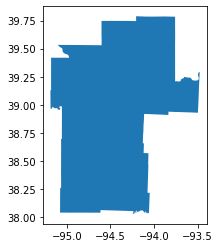

In [21]:
#find central msa geo by area
msa = msa.to_crs(epsg=4326) #set to whatever msa plane crs make sense for your msa
msa['area'] = msa.area
print(msa['area'].idxmax())
msa = msa.iloc[[0]] #replace with idmax output
msa = msa.drop(['level_1'], axis=1)
msa = msa.to_crs(epsg = 4326)
display(msa, msa.plot())

<H1> Custom Geo: Single Count vs msa Comarison </H1>

In [30]:
# seperaet geo dataframes so that they can be conjoined

gdf2 = gdf[gdf['name'] == '443114L']
gdf =  gdf[gdf['name'] != '443114L']

<Axes: >

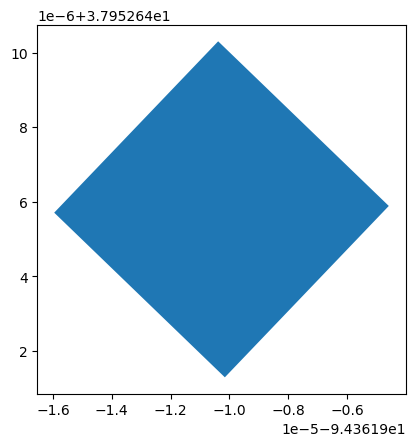

In [42]:
# create the difference of Clay and Florida (i.e. the Florida Donut)
gdf_diff = geopandas.overlay(gdf2,gdf , how='difference')
display(gdf_diff.plot())

In [59]:
gdf_diff.merge(gdf, left_on='name',right_on='name')

,name,geometry_x,geometry_y


In [69]:
# merge florida_difference + Clay all_counties_path to form the Clay vs Florida Comparative Geography
msa_all_counties_path_comp = gdf.append(gdf2)
msa_all_counties_path_comp = msa_all_counties_path_comp.drop('area', axis=1)
display(msa_all_counties_path_comp)
msa_all_counties_path_comp.plot()

AttributeError: 'GeoDataFrame' object has no attribute 'append'

<H1> Custom Geo: All Counties Plus buffer </H1>

In [24]:
msa

,label,geometry,area
0,"Kansas City, MO-KS Area","POLYGON ((-95.18796 39.12891, -95.18013 39.128...",1.984007


<ipython-input-25-297ef22041e6>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  msa_buffer_geoseries = msa.buffer(1)
<ipython-input-25-297ef22041e6>:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  msa_buffer = geopandas.overlay(msa_buffer_df, msa, how='difference')


,label,geometry
0,"Kansas City, MO-KS Area","POLYGON ((-96.18790 39.11812, -96.18407 39.217..."


<AxesSubplot:>

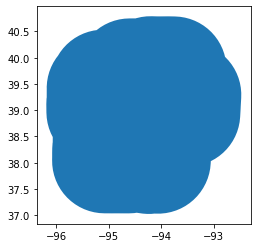

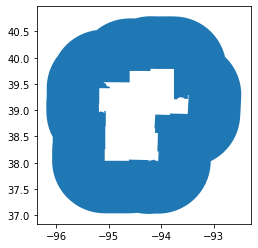

In [25]:
#create florida buffer ring
msa_buffer_geoseries = msa.buffer(1)

data = [['Kansas City, MO-KS Area', msa_buffer_geoseries[0]]] #add your desired label (ie. msa name) here in the first list item
        
msa_buffer_df = geopandas.GeoDataFrame(data, columns = ['label', 'geometry']) 

msa_buffer_df.plot()

msa_buffer = geopandas.overlay(msa_buffer_df, msa, how='difference')

display(msa_buffer, msa_buffer.plot())

In [26]:
#append to all counties

all_counties_comp = msa_buffer.append(all_counties, sort = True)

,geometry,label
0,"POLYGON ((-96.18790 39.11812, -96.18407 39.217...","Kansas City, MO-KS Area"
0,"MULTIPOLYGON (((-94.60226 39.74720, -94.57162 ...","Clinton County, MO"
1,"MULTIPOLYGON (((-95.05626 38.98212, -95.04986 ...","Johnson County, KS"
2,"MULTIPOLYGON (((-95.06583 38.38994, -94.85117 ...","Linn County, KS"
3,"MULTIPOLYGON (((-94.61327 38.38872, -94.61286 ...","Bates County, MO"
4,"MULTIPOLYGON (((-94.60752 39.04409, -94.60735 ...","Jackson County, MO"
5,"MULTIPOLYGON (((-94.60125 39.53037, -94.60066 ...","Platte County, MO"
6,"MULTIPOLYGON (((-94.60173 39.15960, -94.60037 ...","Clay County, MO"
7,"MULTIPOLYGON (((-94.10482 39.14351, -94.09681 ...","Lafayette County, MO"
8,"MULTIPOLYGON (((-95.18089 39.41922, -94.96885 ...","Leavenworth County, KS"


<AxesSubplot:>

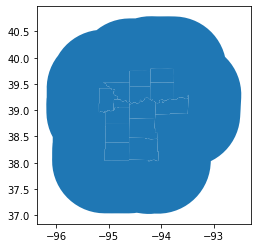

In [27]:
display(all_counties_comp, all_counties_comp.plot())

<H1> Exporting the final files</H1>

In [28]:
# end files we're going to export
all_counties_comp
msa_all_counties_path_comp

,geometry,label
0,"MULTIPOLYGON (((-93.47727 39.29219, -93.48001 ...","Kansas City, MO-KS Area"
0,"MULTIPOLYGON (((-94.60226 39.74720, -94.57162 ...","Clinton County, MO"
1,"MULTIPOLYGON (((-95.05626 38.98212, -95.04986 ...","Johnson County, KS"
2,"MULTIPOLYGON (((-95.06583 38.38994, -94.85117 ...","Linn County, KS"
3,"MULTIPOLYGON (((-94.61327 38.38872, -94.61286 ...","Bates County, MO"
4,"MULTIPOLYGON (((-94.60752 39.04409, -94.60735 ...","Jackson County, MO"
5,"MULTIPOLYGON (((-94.60125 39.53037, -94.60066 ...","Platte County, MO"
6,"MULTIPOLYGON (((-94.60173 39.15960, -94.60037 ...","Clay County, MO"
7,"MULTIPOLYGON (((-94.10482 39.14351, -94.09681 ...","Lafayette County, MO"
8,"MULTIPOLYGON (((-95.18089 39.41922, -94.96885 ...","Leavenworth County, KS"


In [29]:
callback = lambda p: all_counties_comp.to_file(p, driver='GeoJSON')
to_file(callback, 'customgeo_allcounties_vs_msa', 'json')